## Data Science Project: Predicting StreetEasy Rent Prices

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import  mean_squared_error
from sklearn.model_selection import KFold, train_test_split

## Load The Data

In [3]:
# training data with its park and school data
test1_df = pd.read_csv('./csv/SE_rents2018_test1.csv')
train_df = pd.read_csv('./csv/SE_rents2018_train.csv')
train_park_df = pd.read_csv('./csv/number_of_parks_updated.csv')
train_school_df = pd.read_csv('./csv/number_of_schools.csv')

# test2 data and its park and school data
test2_df = pd.read_csv('./csv/SE_rents2018_test2.csv')
test2_park_df = pd.read_csv('./csv/test2_parks.csv')
test2_school_df = pd.read_csv('./csv/test2_schools.csv')

In [4]:
# Append test1 to train_df
train_df = train_df.append(test1_df, ignore_index = True)

## Data Exploration

### Missing Data

In [5]:
cols_with_null = train_df.columns[train_df.isna().any()] # Return columns with null values 

train_df[cols_with_null].isna().sum().sort_values(ascending=False) # Number of null values 

line             4135
floornumber      1502
year_built        470
min_to_subway     143
unit              114
addr_unit         110
description        16
neighborhood        3
bin                 1
dtype: int64

Looks like there are a lot of missing values, especially for floornumber and line. However, from these missing values, it's likely that we will only use floornumber and floorcount for our final model, so we can focus on those.

### Data Distribution

In [6]:
cols = ['bedrooms', 'bathrooms', 'size_sqft', 'floor_count', 'floornumber', 'year_built', 'min_to_subway', 'rent']
train_df[cols].describe()

,bedrooms,bathrooms,size_sqft,floor_count,floornumber,year_built,min_to_subway,rent
count,14000.000000,14000.000000,14000.000000,14000.000000,12498.000000,13530.000000,13857.000000,14000.000000
mean,1.661643,1.238929,848.388643,10.233350,6.198232,1935.773023,63.597067,3591.997214
std,1.084151,0.550979,513.039489,12.003629,7.728606,159.019577,2482.437096,2874.099247
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016700,1250.000000
25%,1.000000,1.000000,604.000000,3.000000,2.000000,1915.000000,1.633300,2250.000000
50%,2.000000,1.000000,800.000000,5.000000,3.000000,1931.000000,2.766700,2900.000000
75%,2.000000,1.000000,1000.000000,12.000000,6.000000,1987.000000,4.383300,3900.000000
max,8.000000,20.000000,10000.000000,90.000000,78.000000,2019.000000,103343.616700,50000.000000


A quick glance at the distribution of these columns tells us a couple things
- It's possible some of the columns are skewed
- There are some fishy values here
    - 20 bathrooms
    - 0 size_sqft
    - 0 floor_count

Let's look at the histogram for these columns to reaffirm some of our observations

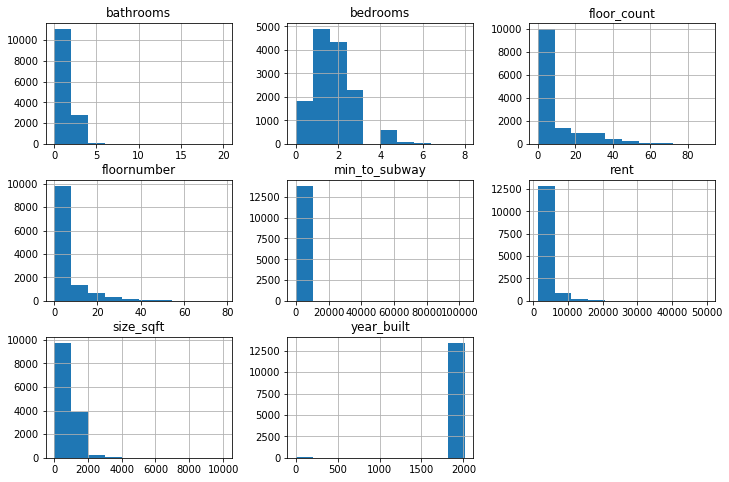

In [7]:
train_df[cols].hist(figsize=(12,8))
plt.show()

### Observations
- As we thought, many of these columns are right skewed.
- There are many outliers present in many of these columns, which may be legit in some cases, but some of them make no sense and will have to be dealt with.


### Visualizing Rent Prices

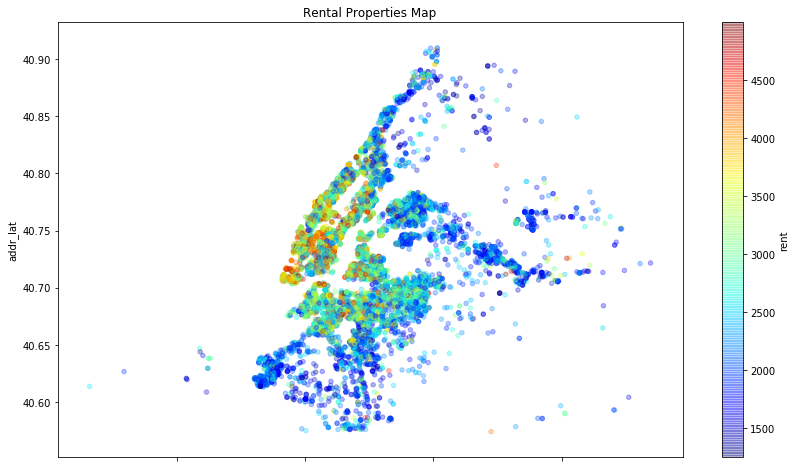

In [17]:
# Most rent prices fall under 5000, so we want to visualize where these places are in NYC
train_df[(train_df['rent'] < 5_000) ].plot(x='addr_lon', y='addr_lat', kind='scatter', alpha=0.3, c='rent', cmap=plt.get_cmap("jet"), colorbar=True, figsize=(14,8))
plt.title('Rental Properties Map')
plt.show()

### Observations
- As expected, most of the higher end rent prices are in Manhattan.
- High rent prices outside of Manhattan still tend to be close to Manhattan.
- Rent prices seem to be fairly high in an area that looks like it's near Battery Park.
- Rent prices are pretty low in the south side of Brooklyn, Bronx, and the east side of Queens.

In [52]:
top_20 = train_df.groupby('neighborhood').median()['rent'].sort_values(ascending=False).head(20)
top_20

neighborhood
Tribeca                            7500.0
Soho                               6800.0
Central Park South                 5675.0
Nolita                             5200.0
Flatiron                           4691.0
DUMBO                              4587.5
Midtown                            4500.0
Greenwich Village                  4500.0
Chelsea                            4474.0
Hillcrest                          4399.5
Stuyvesant Town/PCV                4049.5
West Village                       4000.0
Columbia St Waterfront District    4000.0
Midtown South                      3989.0
Battery Park City                  3911.0
Upper West Side                    3750.0
Morningside Heights                3650.0
Upper East Side                    3600.0
Utopia                             3600.0
Financial District                 3595.0
Name: rent, dtype: float64

In [60]:
train_df['Top20_neighborhood'] = train_df.neighborhood.apply(lambda x: x if x in top_20.index else 'Trash')

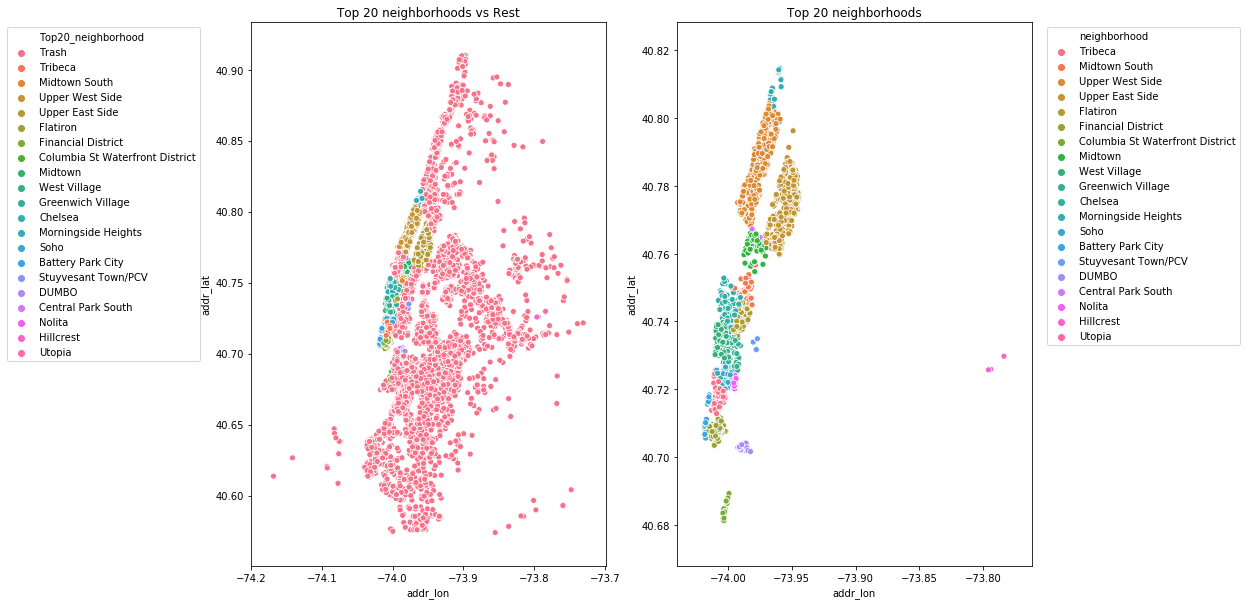

In [123]:
fig, ax = plt.subplots(1,2, figsize=(14,10))

sns.scatterplot(x='addr_lon', y ='addr_lat', data=train_df, hue='Top20_neighborhood', ax=ax[0])
ax[0].legend(loc='upper left', bbox_to_anchor=(-0.7,1))
ax[0].set_title('Top 20 neighborhoods vs Rest')

sns.scatterplot(x='addr_lon', y ='addr_lat' ,data = train_df[train_df['Top20_neighborhood'] != 'Trash'], hue='neighborhood', ax=ax[1])
ax[1].legend(loc='upper right', bbox_to_anchor=(1.6,1))
ax[1].set_title('Top 20 neighborhoods')

plt.show()

#### The top 20 list, as well as the map, gives us an idea of "hot" neighborhoods. 
- The left map gives an idea of where these top 20 neighborhoods are in comparison to the others.
- The right map gives a more focused version containing only the top 20 neighborhoods.
- Using these maps we can hopefully pinpoint the geographic features, as well as neighborhood features, that make a given neighborhood popular.

## Data Cleaning

In [4]:
# Abstracted Data Cleaning Functions
import external_funcs as ef

### Missing Data

In [5]:
# add min_to_subway
train_df['min_to_subway'] = ef.fill_mins_to_subway(train_df)

# add floor_count
train_df['floor_count'] = ef.fill_floor_count(train_df)
train_df.loc[train_df['floor_count'].isna(), 'floor_count'] = [3.0, 3.0, 2.0, 4.0, 7.0, 6.0, 2.0, 5.0, 6.0, 7.0, 6.0, 6.0, 18.0, 3.0, 3.0, 2.0, 4.0, 3.0, 12.0]

# add floornumber
train_df['floornumber'] = ef.fill_floornumber_final(train_df)

# add missing size sqrt
train_df['size_sqft'] = ef.fill_size_sqft(train_df)

### Feature Engineering

In [6]:
train_df['number_of_privileges'] = ef.number_privileges(train_df)
train_df['number_of_parks'] = ef.number_of_parks(train_park_df, train_df)
train_df['number_of_schools'] = ef.number_of_schools(train_school_df, train_df)
train_df['park_level'] = ef.park_level(train_df)
train_df['school_level'] = ef.school_level(train_df)

In [7]:
train_df.head().transpose()

,0,1,2,3,4
rental_id,7236931,7331920,7139224,7364827,7242151
addr_unit,#22A,#406,#18A,#23E,#3B
building_id,551248,3373,70747,42076,319156
bedrooms,4,0,3,1,3
bathrooms,3,1,3,1,1
size_sqft,1300,475,1886,827,1200
created_at,2018-06-04 16:31:06,2018-07-03 20:11:43,2018-05-02 16:10:27,2018-07-13 16:06:55,2018-06-05 16:35:40
addr_street,645 OCEAN AVENUE,93 WORTH STREET,305 EAST 51 STREET,70 WEST 37TH STREET,43 MAC DONOUGH STREET
addr_city,Brooklyn,New York,New York,New York,Brooklyn
addr_zip,11226,10013,10022,10018,11216


## Data Visualization

In [8]:
# Future Implementation

## Model Training

In [9]:
# Crossvalidation Function for classifer

def get_cv_results(classifier, train_df):
    results = []
    k_fold = KFold(n_splits=10)
    
    for train, test in k_fold.split(train_df):
        classifier.fit(train_df.loc[train, features], train_df.loc[train, 'rent'])
        y_predicted = classifier.predict(train_df.loc[test, features])
        accuracy = mean_squared_error(train_df.loc[test, 'rent'], y_predicted)
        results.append(accuracy)
    return np.mean(results), np.std(results)

### Feature Selection

In [10]:
features = [
    'size_sqft', 
    'bathrooms', 
    'number_of_privileges',
    'bedrooms','borough' ,
    'floor_count', 
    'floornumber', 
    'school_level',
    'park_level'
]

# remove unused features
model_df = train_df[(features + ['rent'])]
model_df = pd.get_dummies(model_df)

# redefined features with boroughs 
features = model_df.columns.drop('rent')

In [11]:
# create a holdout set to check for overfitting
model_train_df, model_holdout_df = train_test_split(model_df, test_size=0.2)
model_train_df.reset_index(inplace=True)
model_holdout_df.reset_index(inplace=True)

## Model Selection

### linear Models

In [12]:
# Linear Regression
linear = LinearRegression()
get_cv_results(linear, model_train_df)

(3085725.5921242987, 971956.5719108769)

In [13]:
# Lasso Regressor
LR = Lasso()
get_cv_results(LR, model_train_df)

(3085940.0430372725, 972580.7457358087)

### Ensemble Models

In [14]:
# Random Forest
rforest = RandomForestRegressor(max_depth=7,n_estimators=100)
get_cv_results(rforest, model_train_df)

(1756128.8990577355, 456854.35742391145)

In [15]:
# Ada Boosting
ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=7),learning_rate=.1)
get_cv_results(ada, model_train_df)

(1986135.1434345853, 683951.9404221417)

In [16]:
# Gradient Boost
gbm = GradientBoostingRegressor(
    max_depth=5,
    n_estimators=100
)

get_cv_results(gbm, model_train_df)

(1739779.1272931986, 471589.916525887)

### Test with Holdout Set

In [17]:
# best model
gbm.fit(model_train_df[features], model_train_df['rent'])
predicted = gbm.predict(model_holdout_df[features])

In [18]:
# Mean Square Error
mean_squared_error(model_holdout_df['rent'],predicted)

1008368.767699441

In [19]:
# error interms of $ value (Root Mean Square Error)
mean_squared_error(model_holdout_df['rent'],predicted)**(1/2)

1004.1756657574615

## Model Prediction with Test2

### Add Missing Data And Feature Engineering

In [20]:
# add min_to_subway
test2_df['min_to_subway'] = ef.fill_mins_to_subway(test2_df)

# add floor_count
test2_df['floor_count'] = ef.fill_floor_count(test2_df)

# add floornumber
test2_df['floornumber'] = ef.fill_floornumber_final(test2_df)


# add missing size sqrt
test2_df['size_sqft'] = ef.fill_size_sqft(test2_df)

# feature Engineering
test2_df['number_of_privileges'] = ef.number_privileges(test2_df)
test2_df['number_of_parks'] = ef.number_of_parks(test2_park_df, test2_df)
test2_df['number_of_schools'] = ef.number_of_schools(test2_school_df, test2_df)
test2_df['park_level'] = ef.park_level(test2_df)
test2_df['school_level'] = ef.school_level(test2_df)

### Model Prediction

In [21]:
test2_df = pd.get_dummies(test2_df)
gbm.fit(model_df[features], model_df['rent'])
predicted = gbm.predict(test2_df[features])

In [22]:
test2_submission_df = pd.DataFrame(data = {'predictions': predicted}, index=test2_df['rental_id'])

test2_submission_df.to_csv('test2_submission.csv')
test2_submission_df.head(10)

,predictions
rental_id,
7428577,1830.572330
7454944,2176.471539
7473595,2729.746436
7490488,2331.695879
7460896,3450.786706
7479988,2828.743730
7496308,3697.726269
7468621,3048.321165
7430797,3281.565828


In [23]:
f = list(features)
test2_df[['rental_id'] + f].head(10)

,rental_id,size_sqft,bathrooms,number_of_privileges,bedrooms,floor_count,floornumber,school_level,park_level,borough_Bronx,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island
0,7428577,450.000000,1.0,1,0,4.0,4.0,0,2,0,1,0,0,0
1,7454944,950.000000,1.0,0,2,2.0,2.0,0,1,0,0,0,1,0
2,7473595,702.823361,1.0,2,1,6.0,1.0,1,2,0,0,1,0,0
3,7490488,500.000000,1.0,4,2,7.0,5.0,0,1,0,1,0,0,0
4,7460896,610.000000,1.0,5,1,12.0,11.0,1,2,0,0,1,0,0
5,7479988,900.000000,1.0,5,1,20.0,19.0,0,1,0,0,0,1,0
6,7496308,1233.407283,1.0,3,4,3.0,1.0,1,1,0,1,0,0,0
7,7468621,534.000000,1.0,9,0,12.0,3.0,1,2,0,0,1,0,0
8,7430797,609.000000,1.0,5,1,12.0,2.0,1,1,0,0,1,0,0
9,7440397,1000.000000,1.0,4,1,4.0,2.0,0,1,0,0,1,0,0


### Future Implementations
 1. Add Crime Data with the geolocation